## INITIALIZE: load trial info

In [1]:
import numpy as np
import json
import pandas as pd
import matplotlib as plt
import seaborn as sns

In [2]:
from itertools import product

In [3]:
with open("C:/Users/Sarah Zheng/dev/cards-deception/cards-game/src/assets/trials_40shuffled.json", "r") as read_file:
    trials_source = json.load(read_file)

In [4]:
trials = pd.DataFrame(trials_source)

In [5]:
# add expectation violation levels

trials['exp_violation'] = np.where(trials['outcome'] == -1, trials['outcome'] - trials['outcome'] * (trials['n_red']/5), \
                                   trials['outcome'] - trials['outcome'] * (5-trials['n_red'])/5)

In [150]:
trials['n_blue'] = 5-trials['n_red']

In [151]:
trials.head()

,n_red,outcome,exp_violation,n_blue
0,1,-1,-0.8,4
1,3,-1,-0.4,2
2,2,1,0.4,3
3,1,-1,-0.8,4
4,2,-1,-0.6,3


In [ ]:
sns.lineplot(data=trials.exp_violation, legend=False).set(xlabel="trial", ylabel="expectation violation at each trial")

In [ ]:
# trial-to-trial change in expectation violation
exp_violation_gradient = trials.exp_violation.diff()

In [ ]:
sns.lineplot(data=exp_violation_gradient, legend=False).set(xlabel="trial", ylabel="change in expectation violation")

In [ ]:
# cumulative sum of expectation violation over trials
sns.lineplot(data=trials.exp_violation.cumsum(), legend=False).set(xlabel="trial", ylabel="cumulative range in expectation violation")

In [ ]:
# masks for each level of expectation violation
mask_min08 = trials[trials.exp_violation == '-0.8'].index.tolist()
mask_min06 = trials[trials.exp_violation == '-0.6'].index.tolist()
mask_min04 = trials[trials.exp_violation == '-0.4'].index.tolist()
mask_min02 = trials[trials.exp_violation == '-0.2'].index.tolist()

mask_08 = trials[trials.exp_violation == '0.8'].index.tolist()
mask_06 = trials[trials.exp_violation == '0.6'].index.tolist()
mask_04 = trials[trials.exp_violation == '0.4'].index.tolist()
mask_02 = trials[trials.exp_violation == '0.2'].index.tolist()

masks = [mask_min08, mask_min06, mask_min04, mask_min02, mask_02, mask_04, mask_06, mask_08]

In [ ]:
# get indexes of trials by # red cards = states
idx_n_red = []

for i in set(trials.n_red):
    idxs = trials[trials.n_red == i].index.tolist()
    print("#red cards:", i, "at", idxs)
    idx_n_red.append(idxs)

## get pilot data

In [8]:
# pilot uuids
uuids = ['5fe200ac3803bbcff9845530', 
         '5ff5c230bce45b062a2a06b2', 
         '5f1b05a8703c380d1393bb27', 
         '5b424267e8815c0001777d94', 
         '604294f7bacd9a1a46cf4da5']

In [9]:
import firebase_admin
from firebase_admin import credentials
from firebase_admin import firestore

# Use a service account
cred = credentials.Certificate('D:/Behavioural cybersecurity/project-notes/cards-dd-game-61b9b7f26a6e.json')
firebase_admin.initialize_app(cred)

db = firestore.client()

subjects_ref = db.collection(u'subjects')

In [10]:
# responses query reference
refs = []
for uuid in uuids:
    refs.append(subjects_ref.document(uuid).collection(u'responses').document('main_responses').get())

In [ ]:
# demographics survey query reference
refs_demographics = []
for uuid in uuids:
    refs_demographics.append(subjects_ref.document(uuid).collection(u'responses').document('demographics').get())

In [11]:
# card values
transdict = {'blue': 1, 'red': -1}

In [30]:
# literal card values
transdict2 = {1: 'blue', -1: 'red'}

In [12]:
# result values
results_transdict = {'tie': 0.5, 'loss': 1, 'win': 0}

## Fetch responses from DB

In [13]:
class GameResponses(object):
    def __init__(self, randomPick, randomPickColour, reportColour, RTreport, honestyRating, RThonesty,
                 results, catchRating, RTcatch):
        self.randomPick = randomPick
        self.randomPickColour = randomPickColour
        self.reportColour = reportColour
        self.honestyRating = honestyRating
        self.catchRating = catchRating
        self.RThonesty = RThonesty
        self.RTreport = RTreport
        self.RTcatch = RTcatch
        self.results = results

    @staticmethod
    def from_dict(source):
        gresponse = GameResponses(source[u'randomPick'], source[u'randomPickColour'], source[u'reportColour'],
                                  source[u'RTreport'], source[u'honestyRating'], source[u'RThonesty'], 
                                  source[u'results'], source[u'catchRating'], source[u'RTcatch'])

        return gresponse

    def to_dict(self):
        dest = {
            u'randomPick': self.randomPick,
            u'randomPickColour': self.randomPickColour,
            u'reportColour': self.reportColour,
            u'RTreport': self.RTreport,
            u'honestyRating': self.honestyRating,
            u'RThonesty': self.RThonesty,
            u'results': self.results,
            u'catchRating': self.catchRating,
            u'RTcatch': self.catch
        }

        return dest

In [ ]:
class Demographics(object):
    def __init__(self, age, catch, edlev, gender, twin):
        self.age = age
        self.catch = catch
        self.edlev = edlev
        self.gender = gender
        self.twin = twin

    @staticmethod
    def from_dict(source):
        demos = Demographics(source[u'age'], source[u'catch'], source[u'edlev'],
                                  source[u'gender'], source[u'twin'])

        return demos

    def to_dict(self):
        dest = {
            u'age': self.age,
            u'catch': self.catch,
            u'edlev': self.edlev,
            u'gender': self.gender,
            u'twin': self.twin
        }

        return dest

In [14]:
# main game response data
honestyRatings = []
catchRating = []
reportHonesty = []
gameResults = []
transGameResults = []
RThonesty = []
RTreport = []
randomPickColour = []
reportColour = []

for index, subject in enumerate(refs):
    responses = GameResponses.from_dict(subject.to_dict())
    
    ratings = [int(numeric_string) for numeric_string in responses.honestyRating]
    honestyRatings.append(ratings)
    
    catch = [int(numeric_string) for numeric_string in responses.catchRating]
    catchRating.append(catch)
    
    ifLied = np.array([transdict[x] for x in responses.randomPickColour]) == responses.reportColour
    reportHonesty.append(ifLied)
    
    gameResults.append(responses.results)
    
    transResults = np.array([results_transdict[x] for x in responses.results]) 
    transGameResults.append(transResults)
    
    RThonesty.append(responses.RThonesty)
    RTreport.append(responses.RTreport)
    
    randomPickColour.append([x for x in responses.randomPickColour])
    reportColour.append([x for x in responses.reportColour])

In [162]:
# check when subjects lied

lying_overview = []
lying_counts = []
lying_probable = []

for i in range(len(uuids)):
    lie = 1 - reportHonesty[i]
    tmp_sheet = pd.DataFrame({'random_pick_colour': [transdict[x] for x in randomPickColour[i]], 
                              'reported_colour': reportColour[i], 
                              'lied': lie})
    tmp_sheet = trials.join(tmp_sheet)
    tmp_sheet['lied_colour_probability'] = np.where(tmp_sheet['reported_colour']==-1, np.round(tmp_sheet['n_red']/tmp_sheet['n_blue'], 2), np.round(tmp_sheet['n_blue']/tmp_sheet['n_red'], 2))
    tmp_sheet['lied_colour_probability'] = np.where(tmp_sheet['lied']==1, tmp_sheet['lied_colour_probability'], 0)
    lying_overview.append(tmp_sheet)
    
    lie_blue = sum((tmp_sheet.lied == 1) & (tmp_sheet.reported_colour == 1))
    lie_red = sum((tmp_sheet.lied == 1) & (tmp_sheet.reported_colour == -1))
    lying_counts.append({'count_lie_blue': lie_blue, 'count_lie_red': lie_red, 'average_honesty_rating': np.array(honestyRatings[i]).mean()})
    
    lying_probable

In [163]:
lying_counts = pd.DataFrame(lying_counts)

In [164]:
lying_overview[0].head()

,n_red,outcome,exp_violation,n_blue,random_pick_colour,reported_colour,lied,lied_colour_probability
0,1,-1,-0.8,4,1,-1,1,0.25
1,3,-1,-0.4,2,-1,1,1,0.67
2,2,1,0.4,3,1,-1,1,0.67
3,1,-1,-0.8,4,-1,-1,0,0.00
4,2,-1,-0.6,3,-1,1,1,1.50


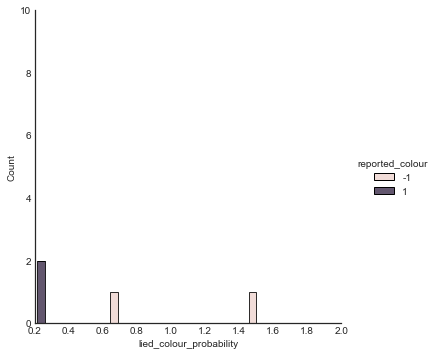

In [178]:
sns.displot(data=lying_overview[3], x='lied_colour_probability', hue='reported_colour', bins=35, multiple='stack').set(xlim=(0.2,2), ylim=(0,10))

In [100]:
from scipy.stats import spearmanr, pearsonr, ttest_ind, wilcoxon, ranksums

In [48]:
pearsonr(lying_counts['average_honesty_rating'], lying_counts['count_lie_blue'])

(-0.7891848733011686, 0.11244825052684987)

In [47]:
pearsonr(lying_counts['average_honesty_rating'], lying_counts['count_lie_red'])

(-0.6149967904317033, 0.2695901711383851)

In [182]:
spearmanr(lying_overview[0].lied_colour_probability, lying_overview[0].random_pick_colour)

SpearmanrResult(correlation=0.0023226118829302155, pvalue=0.9886515231599244)

In [183]:
spearmanr(lying_overview[3].lied_colour_probability, lying_overview[0].random_pick_colour)

SpearmanrResult(correlation=-0.22722002748358947, pvalue=0.15853468944885488)

In [197]:
lying_overview[3].lied_colour_probability[lambda x: x >0].std()

0.5892580080066796

In [195]:
2.67/4

0.6675

In [95]:
lying_counts

,count_lie_blue,count_lie_red,average_honesty_rating
0,10,12,3.175
1,12,2,3.225
2,0,0,5.325
3,2,2,3.425
4,1,0,4.700


In [101]:
ranksums(lying_counts.count_lie_blue, lying_counts.count_lie_red)

RanksumsResult(statistic=0.4177863742936748, pvalue=0.6761033140231469)

In [176]:
import xlsxwriter

writer = pd.ExcelWriter('pilot1_lying_per_subject.xlsx', engine='xlsxwriter')

for i, df in enumerate(lying_overview):
    df.to_excel(writer, sheet_name='subject'+str(i))

writer.save()

## Preprocessing honesty ratings -> suspicion ratings

### [honesty rating] normalize honesty ratings to range [0;1] and reverse-code

In [ ]:
normalized_honesty_ratings = []

for ratings in honestyRatings:
    normed = [(v/6) for v in ratings]
    normalized_honesty_ratings.append(normed)

In [ ]:
# reverse-code honesty ratings to reflect suspicion
import numexpr
suspicionRating = numexpr.evaluate('(6 - honestyRatings)')

In [ ]:
normalized_suspicion_ratings = numexpr.evaluate('(1 - normalized_honesty_ratings)')

In [ ]:
normalized_suspicion_ratings[0]

### [honesty rating] binarize reversed-coded honesty ratings

In [ ]:
binary_suspicion_ratings = []

for ratings in suspicionRating:
    binary = [1 if v >= 4 else 0 for v in ratings]
    binary_suspicion_ratings.append(binary)

In [ ]:
binary_suspicion_ratings[1][0:5]

### [honesty rating] z-scored raw reverse-coded honesty ratings

In [ ]:
# APPROACH 1: get pooled mean and SD stats from all participants
bin_mean_HRs = []
bin_sd_HRs = []

for rating in suspicionRating:
    bin_mean_HRs.append(sum(rating)/len(rating))
    bin_sd_HRs.append(np.array(rating).std())

In [ ]:
z_mean_HRs = np.array(bin_mean_HRs).mean()
z_sd_HRs = np.array(bin_mean_HRs).std()

In [ ]:
# z-scored suspicion ratings compared cross-participants
z_suspicion_ratings = []

for rating in suspicionRating:
    z_rating = [(x-z_mean_HRs)/z_sd_HRs for x in rating]
    z_suspicion_ratings.append(z_rating)

In [ ]:
z_sd_HRs

In [ ]:
# APPROACH 2: z-score each participant's ratings -> takes away inter-subject variance comparison

### [honesty rating] log transform normalized reverse-coded honesty ratings

In [ ]:
tmp_log_suspicionrating = [np.log(v+1) for v in normalized_suspicion_ratings[4]]

In [ ]:
sns.lineplot(data=tmp_log_suspicionrating, legend=False).set(xlabel="trial", ylabel="log normalized honesty rating")

## Initial inspection plots

### plot honesty ratings

In [ ]:
for i in range(len(honestyRatings)):
    sns.lineplot(data=honestyRatings[i], legend=False).set(xlabel="trial", ylabel="honesty rating")

In [ ]:
for i in range(len(honestyRatings)):
    sns.lineplot(data=normalized_suspicion_ratings[i], legend=False).set(xlabel="trial", ylabel="suspicion rating (reversed honesty)")

In [ ]:
# subject that lied most
sns.lineplot(data=honestyRatings[0], legend=False)
sns.lineplot(data=gameResults[0], legend=False).set(xlabel="trial", ylabel="game result")

In [ ]:
# subject that lied most
sns.lineplot(data=honestyRatings[0], legend=False)
sns.lineplot(data=trials.exp_violation, legend=False).set(xlabel="trial", ylabel="expectation violation")

In [ ]:
ev_tmp = exp_violation_gradient.cumsum().fillna(0)

In [ ]:
# subject that lied most
sns.lineplot(data=honestyRatings[0], legend=False)
sns.lineplot(data=ev_tmp, legend=False).set(xlabel="trial", ylabel="cumulative expectation violation")

In [ ]:
# subject that lied most
sns.lineplot(data=honestyRatings[0], legend=False)
sns.lineplot(data=exp_violation_gradient, legend=False).set(xlabel="trial", ylabel="change in expectation violation")

In [ ]:
# subject that lied least
sns.lineplot(data=honestyRatings[2], legend=True)
sns.lineplot(data=gameResults[2], legend=True).set(xlabel="trial", ylabel="game result")

## save specific subject data to .csv file

In [17]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
plt.style.use('seaborn-white')

In [18]:
from matplotlib import ticker

In [ ]:
def create_df_subject(i):
    dict_subject = {
        "trial": range(1,41),
        "n_red": trials.n_red,
        "n_blue": 5-trials.n_red,
        "opponent_report": trials.outcome,
        "expectation_violation": trials.exp_violation,
        "random_pick_colour": [transdict[x] for x in randomPickColour[i]],
        "reported_pick_colour": reportColour[i],
        "honest_card_report": reportHonesty[i],
        "trial_result": transGameResults[i],
        "honesty_rating": honestyRatings[i],
        "RT_honesty": RThonesty[i],
        "normalized_reversed_honesty_rating": normalized_suspicion_ratings[i]
    }

    df_subject = pd.DataFrame(dict_subject)
    df_subject['surprise'] = abs(df_subject['expectation_violation'])
    df_subject['plot_partner_report'] = 1.1
    df_subject['plot_subject_report'] = -0.1
    df_subject['plot_random_pick_colour'] = -0.15
    df_subject['lied'] = df_subject['random_pick_colour'] != df_subject['reported_pick_colour']
    df_subject['colour_incongruent'] = df_subject['reported_pick_colour'] != df_subject['opponent_report']
    df_subject['colour_congruent'] = df_subject['reported_pick_colour'] == df_subject['opponent_report']
    
    df_subject['partner_result'] = [1 if x == 0 else 0 if x == 1 else x for x in df_subject.trial_result.values]
    return df_subject

In [ ]:
markers2 = {"loss": "X", "win": "o", "tie": "D"}
colors = {-1: 'red', 1: 'blue'}

In [ ]:
def create_plot_subject(df_subject, i):
    sns.set(rc={'figure.figsize':(16,7)})
    p = sns.lineplot(data=df_subject, x='trial', y='normalized_reversed_honesty_rating')
    p.set(ylim=(-0.25,1.2), xlim=(0, 41))
    p.set_ylabel('actual normalized reversed honesty ratings')
    p.set_title('Cards game progression subject '+str(i+1))

    p2 = sns.lineplot(data=df_subject, x='trial', y='surprise')
#     p2 = sns.lineplot(data=trials, x='trial', y='normed_signed_colour_count')
    s = sns.scatterplot(data=df_subject, x='trial',y='plot_random_pick_colour', c=[colors[x] for x in df_subject.random_pick_colour])
    s1 = sns.scatterplot(data=df_subject, x='trial',y='plot_subject_report', c=[colors[x] for x in df_subject.reported_pick_colour])
    s2 = sns.scatterplot(data=df_subject, x='trial',y='plot_partner_report', c=[colors[x] for x in df_subject.opponent_report])
    s3 = sns.scatterplot(data=df_subject, x='trial',y='trial_result', markers=markers2, style=gameResults[i])
    s3.xaxis.set_major_locator(ticker.MultipleLocator(1))

    s4 = sns.scatterplot(data=df_subject, x='trial', y=[-0.2 if x else None for x in df_subject.lied])
    s5 = sns.scatterplot(data=df_subject, x='trial', y=[1.15 if x == True else None for x in df_subject.colour_congruent])

In [ ]:
i=0
df_subject = create_df_subject(i)
create_plot_subject(df_subject, i)

In [ ]:
from scipy.stats import spearmanr

spearmanr(df_subject.lied, df_subject.normalized_reversed_honesty_rating)

In [ ]:
sum(df_subject.lied)

In [ ]:
sum((df_subject.random_pick_colour == -1) & (df_subject.reported_pick_colour == 1))

In [ ]:
spearmanr(df_subject.colour_incongruent, df_subject.normalized_reversed_honesty_rating)

In [ ]:
spearmanr(abs(df_subject.expectation_violation), df_subject.normalized_reversed_honesty_rating)

In [ ]:
spearmanr(abs(df_subject.expectation_violation), df_subject.lied)

In [ ]:
spearmanr(df_subject.expectation_violation, df_subject.lied)

In [ ]:
spearmanr(df_subject.normalized_reversed_honesty_rating, df_subject.lied)

In [ ]:
# df_subject.to_csv('pilot_subject1.csv', encoding='utf-8')

In [ ]:
# # export honesty ratings to .csv file
# import csv
# with open('pilot_honestyratings.csv', 'w') as csvfile:
#     csvwriter = csv.writer(csvfile, delimiter=',')
#     csvwriter.writerows(honestyRatings)

### [CONTROL] attention check questions

In [ ]:
# demographics data
edlev = []
catch = []

for subject in refs_demographics:
    demos = Demographics.from_dict(subject.to_dict())
    edlev.append(demos.edlev)
    catch.append(demos.catch)

In [ ]:
catch

In [ ]:
# in-game attention checks
catchRating

In [ ]:
refs_feedback = []

for uuid in uuids:
    refs_feedback.append(subjects_ref.document(uuid).collection(u'responses').document('feedback').get())

In [ ]:
for feedback in refs_feedback:
    print(feedback.to_dict()['studyPurpose'])

### RT honesty ratings

In [ ]:
RThonesty_stats = pd.DataFrame(columns=['mean', 'sd', 'min', 'max'])

for id in RThonesty:
    mean = sum(id)/len(id)
    sd = np.array(id).std()
    vmin = min(id)
    vmax = max(id)
    tmp = {'mean': mean, 'sd': sd, 'min': vmin, 'max': vmax}
    print(tmp)
    RThonesty_stats.append(tmp, ignore_index=True)

## Model fits

### parameter estimation - grid search

In [ ]:
from analysis import *
from specs import * 

In [ ]:
from sklearn.metrics import r2_score

In [ ]:
# process trials
from specs import Trial

Trials = []
for trial in trials_source:
    Trials.append(Trial(n_red=trial['n_red'], outcome=trial['outcome']))

### [model 1] using unsigned suspicion formula

In [ ]:
# parameter grid space
alpha = np.linspace(0.1, 1, 10)
s0 = [-1, -0.6, -0.5, -0.4, -0.3, -0.2, -0.1, 0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 1]

params = (list(product(alpha, s0)))

In [ ]:
params[142]

In [ ]:
# grid search param value fit
best_param_sv_rating = []
all_residuals_sv_rating = []
all_R2_sv_rating = []
best_param_sv_rating_SSE = []
best_param_sv_rating_R2 = []
sklearn_r2 = []

for p, data in enumerate(normalized_suspicion_ratings):
    suspicion_ratings = np.array(data)
    SStot_sv_rating = np.sum((suspicion_ratings-suspicion_ratings.mean())**2)
    SSres_sv_rating = []
    
    for i, param in enumerate(params):
        print("iterating parameter set", i)
        g = Game(Trials, Player(alpha=param[0], pre_suspicion=param[1]))
        g.simulate_unsigned(verbose=False, save=False, add_noise=False)

#         sim_sv_rating = g.unsigned_suspicion_to_honesty_rating()
        sim_sv_rating = g.unsigned_expectation_violation
        residuals_sv_rating = np.sum((suspicion_ratings-sim_sv_rating)**2)
        SSres_sv_rating.append(residuals_sv_rating)
        
        sklearn_r2.append(r2_score(data, sim_sv_rating))
        
    R2_sv_rating = 1 - np.divide(SSres_sv_rating, SStot_sv_rating)
    all_residuals_sv_rating.append(SSres_sv_rating)
    all_R2_sv_rating.append(R2_sv_rating)
    
    best_idx_sv_rating = np.array(SSres_sv_rating).argmin()
    best_param_sv_rating.append(params[best_idx_sv_rating])
    best_param_sv_rating_SSE.append(np.array(SSres_sv_rating).min())
    best_param_sv_rating_R2.append(R2_sv_rating[best_idx_sv_rating])

In [ ]:
best_param_sv_rating

In [ ]:
len(params) #* len(uuids)

In [ ]:
best_param_sv_rating_R2

In [ ]:
max(sklearn_r2[:150])

In [ ]:
np.array(all_residuals_sv_rating[0]).argmin()

In [ ]:
params[98]

### [model 2] signed suspicion model

In [ ]:
# parameter search space

alpha = np.linspace(0.01,1,100)
s0 = 0

In [ ]:
alpha

In [ ]:
generated_suspicion

In [ ]:
generated_suspicion.mean()

In [ ]:
t = generated_suspicion - generated_suspicion.mean()

In [ ]:
t

In [ ]:
t ** 2

In [ ]:
sum(t ** 2)

In [ ]:
SStot_sv

In [ ]:
y = SSres_sv[-1]

In [ ]:
y

In [ ]:
SSres_sv = []
generated_suspicion = normalized_suspicion_ratings[0]
SStot_sv = np.sum((generated_suspicion - generated_suspicion.mean())**2)
logs = []

for i, param in enumerate(alpha):
    g = Game(Trials, Player(alpha=param, pre_suspicion=s0))
    g.simulate_signed(verbose=False, save=False, add_noise=False)

    sv = np.array(g.suspicion_values)
    print("model output", sv)
    sv = normalized_array(sv, s0)
    print("normalized model output", sv)
    residuals_sv = np.sum((generated_suspicion-sv)**2)
    SSres_sv.append(residuals_sv)
    tmp = pd.DataFrame(g.sim_log)
    tmp['normalized_estimated_suspicion'] = g.normalize_signed_suspicion()
    tmp['normalized_actual_suspicion_ratings_subject1'] = generated_suspicion
    logs.append(tmp)
    
R2_sv = 1 - np.divide(SSres_sv, SStot_sv)

In [ ]:
R2_sv.argmax()

In [ ]:
alpha[76]

In [ ]:
R2_sv

In [ ]:
import xlsxwriter

writer = pd.ExcelWriter('pilot_subject1_signed-suspicion-noprior_gridsearch.xlsx', engine='xlsxwriter')

for i, df in enumerate(logs):
    df.to_excel(writer, sheet_name='fit_alpha_'+str(alpha[i]))

writer.save()

In [ ]:
alpha[1]

In [ ]:
summary = pd.DataFrame({'alpha': alpha, 'SS_res': SSres_sv, 'SS_tot': [SStot_sv]*len(alpha), 'R_squared': R2_sv})

In [ ]:
summary.to_csv('pilot_subject1_signed-suspicion-noprior_gridsearch_results.csv')

### [model 3] using softmax probability

In [ ]:
def param_recovery_proba(x, params):
    '''returns sum of squared residuals for each fitted parameter value combination, and best parameter values index'''
    SSres = []
    for param in params:
        player = Player(alpha=param[0], beta=param[1])
        g = Game(trials, player)
        g.simulate(verbose=False)
        ps = np.array(g.softmax_probabilities)
        SSres.append(sum((x-ps)**2))
    minimum_idx = np.where(SSres == np.amin(SSres))[0]
    print("SSresiduals minimum index:", minimum_idx)
    for idx in minimum_idx:
        print("BEST PARAMETER ESTIMATES:", params[idx])
    return np.array(SSres), minimum_idx

In [ ]:
def df_best_estimations(x, params):
    '''generates long dataframe with estimated and actual data'''
    x = np.array(x)
    SSres, best_params_idx = param_recovery_proba(x, params)
    SStot = sum([(v-x.mean())**2 for v in x])
    R2 = 1-SSres[best_params_idx]/SStot
    
    best_sim = Game(trials, Player(alpha=params[best_params_idx[0]][0], beta=params[best_params_idx[0]][1]))
    best_sim.simulate(verbose=False)
    best_estimated_proba = best_sim.softmax_probabilities
    
    df = pd.DataFrame({'value': best_estimated_proba, 'label': ['estimated'] * len(best_estimated_proba)})
    df = df.append(pd.DataFrame({'value': x, 'label': ['actual'] * len(x)}), ignore_index=False)
    print("SSres", SSres[best_params_idx])
    print("SStot", SStot)
    print("R squared:", R2)
    return df

In [ ]:
df = df_best_estimations(normalized_suspicion_ratings[0], params)
sns.lineplot(data=df, x=df.index, y='value', hue='label').set(xlabel="trial", ylabel="p(deception)")

In [ ]:
df = df_best_estimations(transGameResults[4], params)
sns.lineplot(data=df, x=df.index, y='value', hue='label').set(xlabel="trial win/loss/tie", ylabel="p(deception)")

### [model 4] fit simple colour report counts tracking model

In [ ]:
# add partner colour report outcome counts to trial

count_red = abs(trials.outcome[lambda x: x==-1].cumsum())
count_blue = abs(trials.outcome[lambda x: x==1].cumsum())

trials['colour_count'] = count_red.append(count_blue).sort_index()

In [ ]:
trials['colour_count_prop'] = trials.colour_count/len(trials)

In [ ]:
trials.head()

In [ ]:
# approach 1: track proportion of reported colours

prop_trial_red = []
prop_trial_blue = []

t_burnin = 0 # how many trials in memory

for i in range(len(trials)):
    tmp = trials.outcome[:i]
    n_red = abs(tmp[lambda x: x==-1].cumsum())
    n_blue = abs(tmp[lambda x: x==1].cumsum())
    prop_trial_red.append(n_red/i)
    prop_trial_blue.append(n_blue/i)

In [ ]:
prop_trial_red[2].iloc[-1]

In [ ]:
# approach 2: track # same consecutive colour reports since the reported colour changed

track_freq = [1] * len(trials)

for i, outcome in enumerate(trials.outcome.values):
    if (i==0):
        continue
    if (i>0):
        if (outcome != trials.outcome.values[i-1]):
            continue
        if (outcome == trials.outcome.values[i-1]):
            track_freq[i] = track_freq[i-1] + 1

In [ ]:
trials['trial'] = trials.index + 1

In [ ]:
trials['n_consec_colour'] = track_freq

In [ ]:
trials['signed_n_consec_colour'] = trials['n_consec_colour'] * trials['outcome']

In [ ]:
tmp = (trials.signed_n_consec_colour + 5)/9
trials['normed_signed_colour_count'] = tmp

In [ ]:
def fit_count_tracker(data, params):
    data = np.array(data)
    ss_tot = np.sum((data - data.mean())**2)
    ss_res = []
    for param in params:
        alpha = param[0]
        prior = param[1]
        estimated = np.array(trials.normed_signed_colour_count * alpha + prior)
        ss_res.append(np.sum((data - estimated)**2))
    r2 = 1 - np.divide(ss_res, ss_tot)
    best_params = params[np.array(r2).argmax()]
    return best_params, r2

In [ ]:
# parameter grid space
alpha = np.linspace(0.1, 1, 10)
prior = [-0.2, -0.1, 0, 0.1, 0.2]

params = (list(product(alpha, prior)))

In [ ]:
best_params, r2 = fit_count_tracker(normalized_suspicion_ratings[1], params)

In [ ]:
best_params, r2 = fit_count_tracker(normalized_suspicion_ratings[4], params)

In [ ]:
r2.max()

In [ ]:
best_params

In [ ]:
sns.lineplot(data=trials.normed_signed_colour_count * 0.8 - 0.2)
sns.lineplot(data=normalized_suspicion_ratings[4])

## overall analyses across participants

In [ ]:
from scipy.stats import pearsonr

In [ ]:
from scipy.stats import spearmanr

In [ ]:
# correct RT report cumulative values
rtreport0_tmp = pd.Series(RTreport[0]).diff().fillna(RTreport[0][0])

In [ ]:
spearmanr(rtreport0_tmp, honestyRatings[0])

In [ ]:
# average honesty rating and SD
avgHonestyRatings = []
sdHonestyRatings = []

for index, ratings in enumerate(honestyRatings):
#     print(index, ratings)
    ratingsInt = [int(numeric_string) for numeric_string in ratings]
    mean = sum(ratingsInt)/len(ratingsInt)
    avgHonestyRatings.append(mean)
    sd = np.std(ratingsInt)
    sdHonestyRatings.append(sd)
    print("average honesty rating", mean, "std", sd)

In [ ]:
avgHonestyRatings

In [ ]:
sdHonestyRatings

In [ ]:
propLied = []

for index, report in enumerate(reportHonesty):
#     print(index, report)
    lieProportion = (len(report) - sum(report)) / len(report)
    print(lieProportion)
    propLied.append(lieProportion)

In [ ]:
# aggregate pearson's correlation proportion the participant lied and average honesty rating
pearsonr(propLied, avgHonestyRatings)

In [ ]:
spearmanr(propLied, avgHonestyRatings)

In [ ]:
# aggregate game results per participant
wins = []
losses = []
ties = []

for result in gameResults:
    unique, counts = np.unique(result, return_counts=True)
    outcome = dict(zip(unique, counts))
    wins.append(outcome['win'])
    losses.append(outcome['loss'])
    ties.append(outcome['tie'])
#     print(outcome)

In [ ]:
# aggregate spearman's correlation game results (win/loss/tie) & average honesty rating
spearmanr(avgHonestyRatings, wins)
spearmanr(avgHonestyRatings, losses)
spearmanr(avgHonestyRatings, ties)

# no correlation at all between game outcome and honesty rating

In [ ]:
# rank-based spearman's correlation game results (win/loss/tie) & honesty rating
for i in range(len(RThonesty)):
    cor = spearmanr(transGameResults[i], honestyRatings[i])
    print(cor)

In [ ]:
# rank-based spearman's correlation game results (win/loss/tie) & RT honesty rating
for i in range(len(RThonesty)):
    cor = spearmanr(transGameResults[i], RThonesty[i])
    print(cor)

In [ ]:
# get individual correlates level of expectation violation

for i in range(len(uuids)):
    for index, mask in enumerate(masks):
        print("=" * 50)
        print("participant", i)
        print(transGameResults[i][mask])
        print(np.array(RThonesty[i])[mask])
        pcorr = pearsonr(transGameResults[i][mask], np.array(RThonesty[i])[mask])
        scorr = spearmanr(transGameResults[i][mask], np.array(RThonesty[i])[mask])
        print(index, "pearson's r", pcorr)
        print(index, "spearman's r", scorr)

In [ ]:
# get individual correlates level of expectation violation

for i in range(len(uuids)):
    for index, mask in enumerate(masks):
        print("=" * 50)
        print("participant", i)
        rating = np.array(honestyRatings[i])[mask]
        RT = np.array(RThonesty[i])[mask]
        print(rating)
        print(RT)
        pcorr = pearsonr(rating, RT)
        scorr = spearmanr(rating, RT)
        print(index, "pearson's r", pcorr)
        print(index, "spearman's r", scorr)

In [ ]:
# correlate how much participant lied per level with average honesty rating for each level of expectation violation
# i.e. r(lied, honestyrating) | exp_violation

avg_rating = []
avg_prop_lie = []

for index, mask in enumerate(masks):
    for i in range(len(uuids)):      
        rating = np.array(honestyRatings[i])[mask]
        lied = np.array(reportHonesty[i])[mask]
        
        mean_rating = sum(rating)/len(rating)
        n_lied = (len(lied)-sum(lied))/len(lied)
        
        avg_rating.append(mean_rating)
        avg_prop_lie.append(n_lied)
#         print("=" * 50)
#         print("participant", i)
#         print(rating)
#         print(lied)
#         print(mean_rating)
#         print(n_lied)

In [ ]:
spearmanr(avg_rating[0:4], avg_prop_lie[0:4])

In [ ]:
spearmanr(avg_rating[5:9], avg_prop_lie[5:9])

In [ ]:
spearmanr(avg_rating[10:14], avg_prop_lie[10:14])

In [ ]:
spearmanr(avg_rating[15:19], avg_prop_lie[15:19])

In [ ]:
spearmanr(avg_rating[20:24], avg_prop_lie[20:24])

In [ ]:
spearmanr(avg_rating[25:29], avg_prop_lie[25:29])

In [ ]:
spearmanr(avg_rating[30:34], avg_prop_lie[30:34])

In [ ]:
spearmanr(avg_rating[35:39], avg_prop_lie[35:39])

In [ ]:
# inspect correlation  between exp_violation and avg_prop_lie


In [ ]:
# logistic regression or nlme for honestyrating <- result; lying <- result
